**Goal**: this notebook simply reruns the examples of the paper “Quantifying Attention Flow In Transformers”, ACL 2020, with the same NLP examples.

In [1]:
import numpy as np
import torch
import seaborn as sns
import itertools 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import os

rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

In [3]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
        aug_att_mat =  att_mat
    
    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

    cls_att = np.flip(att[:,s_position, t_positions], axis=0)
    xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
    return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
    mats = np.zeros((n_layers,l,l))

    for i in np.arange(n_layers):
        mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]

    return mats

In [4]:
MODEL_FOLDER = "../huggingface_models/bert-base-uncased"

In [5]:
from transformers import AutoTokenizer, BertForMaskedLM

if os.path.exists(os.path.join(MODEL_FOLDER, "pytorch_model.bin")):
    print("Model loaded locally...")
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_FOLDER, use_fast=True)
    model = BertForMaskedLM.from_pretrained(MODEL_FOLDER)
else:
    print("Model downloaded...")
    
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
    model = BertForMaskedLM.from_pretrained("bert-base-uncased")
    
    tokenizer.save_pretrained(MODEL_FOLDER)
    model.save_pretrained(MODEL_FOLDER)
model.zero_grad()
print(model)

Model loaded locally...
BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [6]:

sentences = {}
src = {}
targets = {}
sentences[1] = "She asked the doctor about "+tokenizer.mask_token+" backache"
src[1] = 6
targets[1] = (1,4) 
sentences[0] = "He talked to her about his book"
src[0] = 6
targets[0] = (1,4) 
sentences[2] = "The author talked to Sara about "+tokenizer.mask_token+" book"
src[2] = 7
targets[2] = (2,5) 

sentences[3] = "John tried to convince Mary of his love and brought flowers for "+tokenizer.mask_token
src[3] = 13
targets[3] = (1,5) 

sentences[4] = "Mary convinced John of "+tokenizer.mask_token+" love"
src[4] = 5
targets[4] = (1,3) 


# Predict a new sentence

In [7]:

ex_id = 2
sentence = sentences[ex_id]
tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']
print(len(tokens), tokens)
input_ids = tokenizer.encode(sentence)
# input_ids = tokenizer(sentence, return_tensors="pt").input_ids
input_ids = torch.tensor([input_ids])

10 ['[cls]', 'the', 'author', 'talked', 'to', 'sara', 'about', '[MASK]', 'book', '[sep]']


In [8]:
#input_ids = tokenizer.encode(sentence)
#print(tokenizer.decode(input_ids))
model_output = model(
    input_ids,
    output_hidden_states=True,
    output_attentions=True,)
all_hidden_states, all_attentions  = model_output['hidden_states'], model_output['attentions']

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

(12, 12, 10, 10)


In [9]:
input_ids

tensor([[ 101, 1996, 3166, 5720, 2000, 7354, 2055,  103, 2338,  102]])

In [10]:
output = model(input_ids)[0]
predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])

flat_input_ids = list(input_ids.flatten())

print(np.argmax(output.detach().numpy()[0], axis=-1))
print(tokenizer.decode(np.argmax(output.detach().numpy()[0], axis=-1)))
print(flat_input_ids[src[ex_id]], tokenizer.decode([flat_input_ids[src[ex_id]]]))
print(flat_input_ids[targets[ex_id][0]], tokenizer.decode([flat_input_ids[targets[ex_id][0]]]), predicted_target[flat_input_ids[targets[ex_id][0]]])
print(flat_input_ids[targets[ex_id][1]], tokenizer.decode([flat_input_ids[targets[ex_id][1]]]), predicted_target[flat_input_ids[targets[ex_id][1]]])

his_id = tokenizer.encode('his')[1]
her_id = tokenizer.encode('her')[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id], "her prob:", predicted_target[her_id], "her?", predicted_target[her_id] > predicted_target[his_id])

[1012 1996 3166 5720 2000 7354 2055 1996 1012 1012]
. the author talked to sara about the..
tensor(103) [MASK]
tensor(3166) author tensor(5.9873e-06, grad_fn=<SelectBackward0>)
tensor(7354) sara tensor(5.9435e-07, grad_fn=<SelectBackward0>)
2010 2014
his prob: tensor(0.0700, grad_fn=<SelectBackward0>) her prob: tensor(0.1019, grad_fn=<SelectBackward0>) her? tensor(True)


<ipython-input-10-318e4fb1725f>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])


In [11]:
output.shape

torch.Size([1, 10, 30522])

/home/paltenmo/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

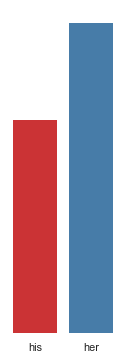

In [12]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['his', 'her'], [ float(predicted_target[his_id].detach().numpy()),  float(predicted_target[her_id].detach().numpy())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
#plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

<AxesSubplot:>

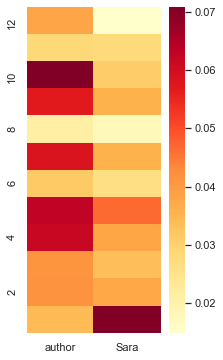

In [13]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], src[ex_id], t_positions=targets[ex_id], sentence=sentence)


In [24]:
import inspect

x, y, z = 1, 2, 3

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def see_type_and_shape(matrix):
    str_type = str(type(matrix))
    try:
        shape = str(matrix.shape)
    except:
        shape = "No shape - " + str(len(matrix))
    var_name = retrieve_name(matrix)
    print(f"({var_name}) type: {str_type}. Shape: {shape}")

In [25]:
see_type_and_shape(attentions_mat)

(['attentions_mat']) type: <class 'numpy.ndarray'>. Shape: (12, 12, 10, 10)


In [41]:
#@title Get raw attention mat + residual coonections
see_type_and_shape(attentions_mat)

res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
see_type_and_shape(res_att_mat)
print("cum.sum.", res_att_mat.sum())

res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
#res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
print("cum.sum.", res_att_mat.sum())

print(np.eye(res_att_mat.shape[1])[None,None,...].shape)
see_type_and_shape(res_att_mat)
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)
see_type_and_shape(res_adj_mat)


(['attentions_mat']) type: <class 'numpy.ndarray'>. Shape: (12, 12, 10, 10)
(['res_att_mat']) type: <class 'numpy.ndarray'>. Shape: (12, 10, 10)
cum.sum. 120.0
cum.sum. 239.99999977147672
(1, 1, 10, 10)
(['res_att_mat']) type: <class 'numpy.ndarray'>. Shape: (12, 10, 10)
(['res_adj_mat']) type: <class 'numpy.ndarray'>. Shape: (130, 130)


In [29]:
for key in res_labels_to_index:
    print(key)

0_[cls]
1_the
2_author
3_talked
4_to
5_sara
6_about
7_[MASK]
8_book
9_[sep]
L1_0
L1_1
L1_2
L1_3
L1_4
L1_5
L1_6
L1_7
L1_8
L1_9
L2_0
L2_1
L2_2
L2_3
L2_4
L2_5
L2_6
L2_7
L2_8
L2_9
L3_0
L3_1
L3_2
L3_3
L3_4
L3_5
L3_6
L3_7
L3_8
L3_9
L4_0
L4_1
L4_2
L4_3
L4_4
L4_5
L4_6
L4_7
L4_8
L4_9
L5_0
L5_1
L5_2
L5_3
L5_4
L5_5
L5_6
L5_7
L5_8
L5_9
L6_0
L6_1
L6_2
L6_3
L6_4
L6_5
L6_6
L6_7
L6_8
L6_9
L7_0
L7_1
L7_2
L7_3
L7_4
L7_5
L7_6
L7_7
L7_8
L7_9
L8_0
L8_1
L8_2
L8_3
L8_4
L8_5
L8_6
L8_7
L8_8
L8_9
L9_0
L9_1
L9_2
L9_3
L9_4
L9_5
L9_6
L9_7
L9_8
L9_9
L10_0
L10_1
L10_2
L10_3
L10_4
L10_5
L10_6
L10_7
L10_8
L10_9
L11_0
L11_1
L11_2
L11_3
L11_4
L11_5
L11_6
L11_7
L11_8
L11_9
L12_0
L12_1
L12_2
L12_3
L12_4
L12_5
L12_6
L12_7
L12_8
L12_9


# Raw Attention Weights

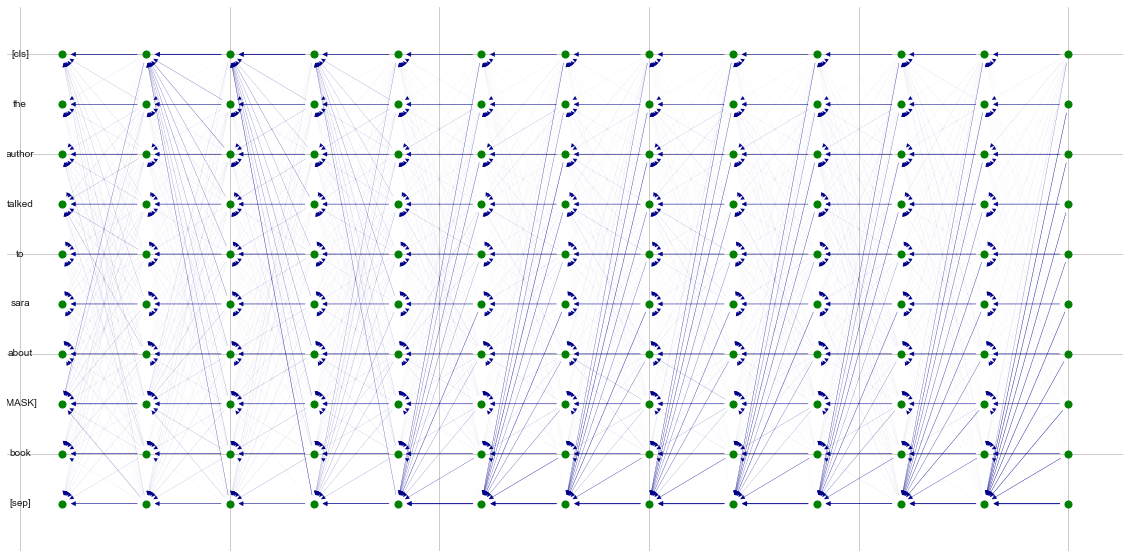

In [15]:
#@title plot the attention graph
plt.figure(figsize=(20,10))
res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

<AxesSubplot:>

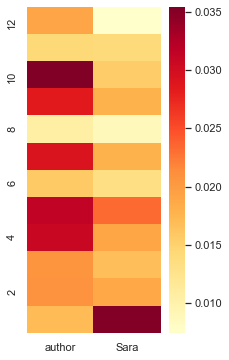

In [16]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(res_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)


# Att. Rollout (multiplicative)

In [42]:
res_att_mat.shape

(12, 10, 10)

In [16]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


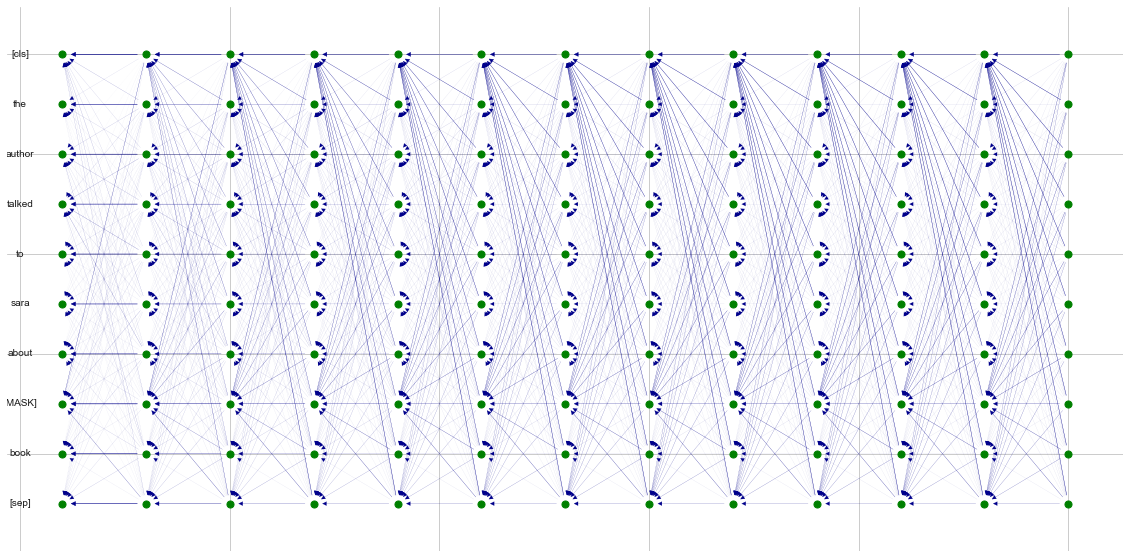

In [17]:
#@title Draw attention rollout graph
plt.figure(figsize=(20,10))
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

<AxesSubplot:>

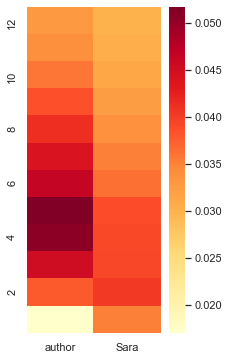

In [18]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)


# Att. Flow (min)

In [19]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])


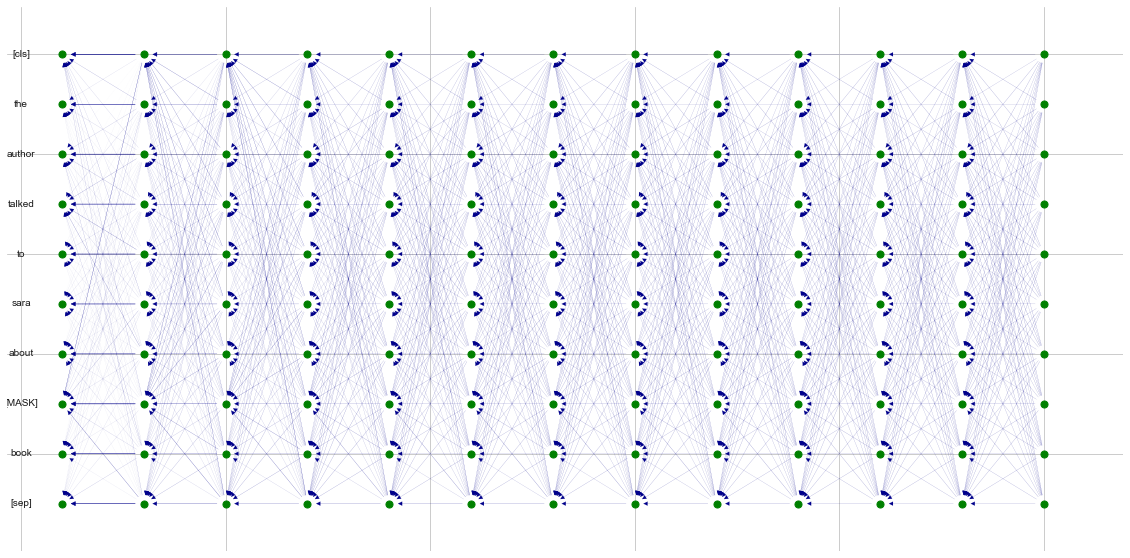

In [20]:
#@title Draw attention flow graph

plt.figure(figsize=(20,10))
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

<AxesSubplot:>

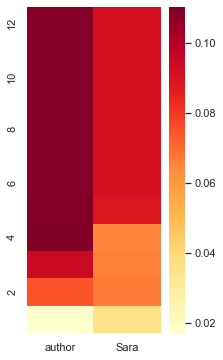

In [21]:
#@title Plot contrastive heatmap
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)